In [1]:
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report


In [2]:
# Pre-processing methods for the dataset

def get_array_of_matrix(dataset):
    array_of_images = []
    for row in dataset:
        row = np.asarray(row)
        matrix = np.reshape(row, (48, 48))
        array_of_images.append(matrix)
    return array_of_images


def crop_dataset(dataset, row, clmn):
    copped_dataset = []
    for image in dataset:
        y, x = image.shape
        first_x = x//2-(row//2)
        first_y = y//2-(clmn//2)
        copped_dataset.append(image[first_y:first_y + clmn, first_x:first_x + row])
    return copped_dataset


def reshape_dataset(dataset):
    reshaped_dataset = []
    for image in dataset:
        image = cv.resize(image, (48, 48)) # un po' bruttino
        image = image.flatten()
        reshaped_dataset.append(image)
    # reshaped_dataset = np.reshape(reshaped_dataset, (12660, 2304)) # un po' bruttino
    return reshaped_dataset


def apply_adaptive_threshold(dataset):
    dataset_with_filter = []
    for image in dataset:
        image = cv.adaptiveThreshold(image, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)
        image = image.flatten()
        dataset_with_filter.append(image)
    dataset_with_filter = np.reshape(dataset_with_filter, (12660, 1600))
    return dataset_with_filter

In [3]:
x_train_gr_smpl = pd.read_csv("./datasets/x_train_gr_smpl.csv", delimiter=",", dtype=np.uint8)
y_train_smpl = pd.read_csv("./datasets/y_train_smpl.csv", delimiter=",", dtype=np.uint8)

In [4]:
dataset = np.asmatrix(x_train_gr_smpl)
aom_dataset = get_array_of_matrix(dataset)
cropped_dataset = crop_dataset(aom_dataset, 40, 40) # un po' bruttino
#new_dataset = reshape_dataset(cropped_dataset)
new_dataset = apply_adaptive_threshold(cropped_dataset)

In [5]:
# add y_train_smpl to new_dataset ---KARAN
dataset = np.append(new_dataset, y_train_smpl, axis=1)
x = dataset[:, 0:1599]
y = dataset[:, -1]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.33, random_state=17)

In [6]:
# Create a pandas dataframe  
dataframe = pd.DataFrame(data=dataset, index=None,columns=None,dtype=np.uint8, copy=False)


# Clustering

Source: udemy.com

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
scaler = StandardScaler()

In [9]:
dataframe.rename(columns ={1600:"Label"}, inplace =True) #Renaming the last column as "Label"
scaler.fit(dataframe.drop("Label", axis=1))# Fit the data to all columns except Labels
scaled_features = scaler.transform(dataframe.drop("Label", axis=1))
df_feat = pd.DataFrame(scaled_features,columns=dataframe.columns[:-1])

C:\Users\singh\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\singh\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
X = df_feat
y = dataframe["Label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
from sklearn.neighbors import KNeighborsClassifier

In [12]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='uniform')

In [13]:
pred = knn.predict(X_test)

In [14]:
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

[[355  61   0   0   0   3   0   0   0   0]
 [ 80 479   0   0   0   4   0   0   1   0]
 [  1   2 125   0   0   1   0   2   0   0]
 [  9   1   0 393   1   1   0   0   0   0]
 [  5   1   0   0 622   1   0   0   1   0]
 [  2   0   0   0   0 675   0   0   0   0]
 [  1   1   1   0   0   0 233   0   1   0]
 [  6   4   1   0   0   0   0  53   0   0]
 [ 18   4   0   0   0   4   0   0 545   0]
 [  1   0   0   0   0   0   0   0   0  99]]
              precision    recall  f1-score   support

           0       0.74      0.85      0.79       419
           1       0.87      0.85      0.86       564
           2       0.98      0.95      0.97       131
           3       1.00      0.97      0.98       405
           4       1.00      0.99      0.99       630
           5       0.98      1.00      0.99       677
           6       1.00      0.98      0.99       237
           7       0.96      0.83      0.89        64
           8       0.99      0.95      0.97       571
           9       1.00     

In [15]:
knn2 = KNeighborsClassifier(n_neighbors=1)# Only 1 cluster
knn2.fit(X_train,y_train)
pred2 = knn2.predict(X_test)
print(confusion_matrix(y_test,pred2))
print(classification_report(y_test,pred2))

[[359  58   0   0   0   2   0   0   0   0]
 [ 60 502   0   1   0   1   0   0   0   0]
 [  2   1 127   0   0   1   0   0   0   0]
 [  6   0   0 397   1   0   0   0   1   0]
 [  0   0   0   0 627   2   1   0   0   0]
 [  1   0   0   0   0 676   0   0   0   0]
 [  0   0   1   0   0   0 236   0   0   0]
 [  2   0   0   0   0   0   0  62   0   0]
 [  9   3   0   0   0   0   0   0 559   0]
 [  0   1   0   0   0   0   0   0   0  99]]
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       419
           1       0.89      0.89      0.89       564
           2       0.99      0.97      0.98       131
           3       1.00      0.98      0.99       405
           4       1.00      1.00      1.00       630
           5       0.99      1.00      0.99       677
           6       1.00      1.00      1.00       237
           7       1.00      0.97      0.98        64
           8       1.00      0.98      0.99       571
           9       1.00     

#### Varying the clusters

In [16]:
error_rate =[]

for i in range(1,20):
    knn=KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test)) #Average predictions not equal to test values

Text(0, 0.5, 'Error Rate')

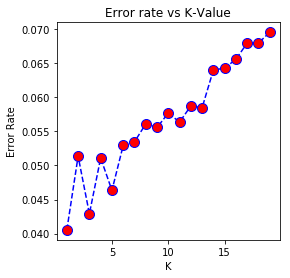

In [17]:
plt.figure(figsize=(4,4))
plt.plot(range(1,20),error_rate,color="blue",linestyle='dashed',marker="o",markerfacecolor="red",markersize=10)
plt.title("Error rate vs K-Value")
plt.xlabel("K")
plt.ylabel("Error Rate")

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
x_train_emb3 = TSNE(n_components=3, perplexity=35).fit_transform(X_train)

In [ ]:
print(x_train_emb3.shape)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)
for label in range(10):
    x_train_tmp = x_train_emb3[y_train==label]
    ax.scatter(x_train_tmp[:,0],x_train_tmp[:,1],alpha=0.75, label=label)
ax.legend()
plt.show()